11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step
Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 597ms/step - accuracy: 0.4903 - loss: 1.5421 - val_accuracy: 0.0860 - val_loss: 2.6004
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.8893 - loss: 0.3607 - val_accuracy: 0.0860 - val_loss: 2.4738
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9235 - loss: 0.2496 - val_accuracy: 0.4640 - val_loss: 1.6357
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.9363 - loss: 0.2190 - val_accuracy: 0.7980 - val_loss: 0.5668
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9478 - loss: 0.1853 - val_accuracy: 0.8560 - val_loss: 0.4097
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9477 - loss: 0.1603 - val_accuracy: 0.6440 - val_loss: 1.4130
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9546 - loss: 0.1467 -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


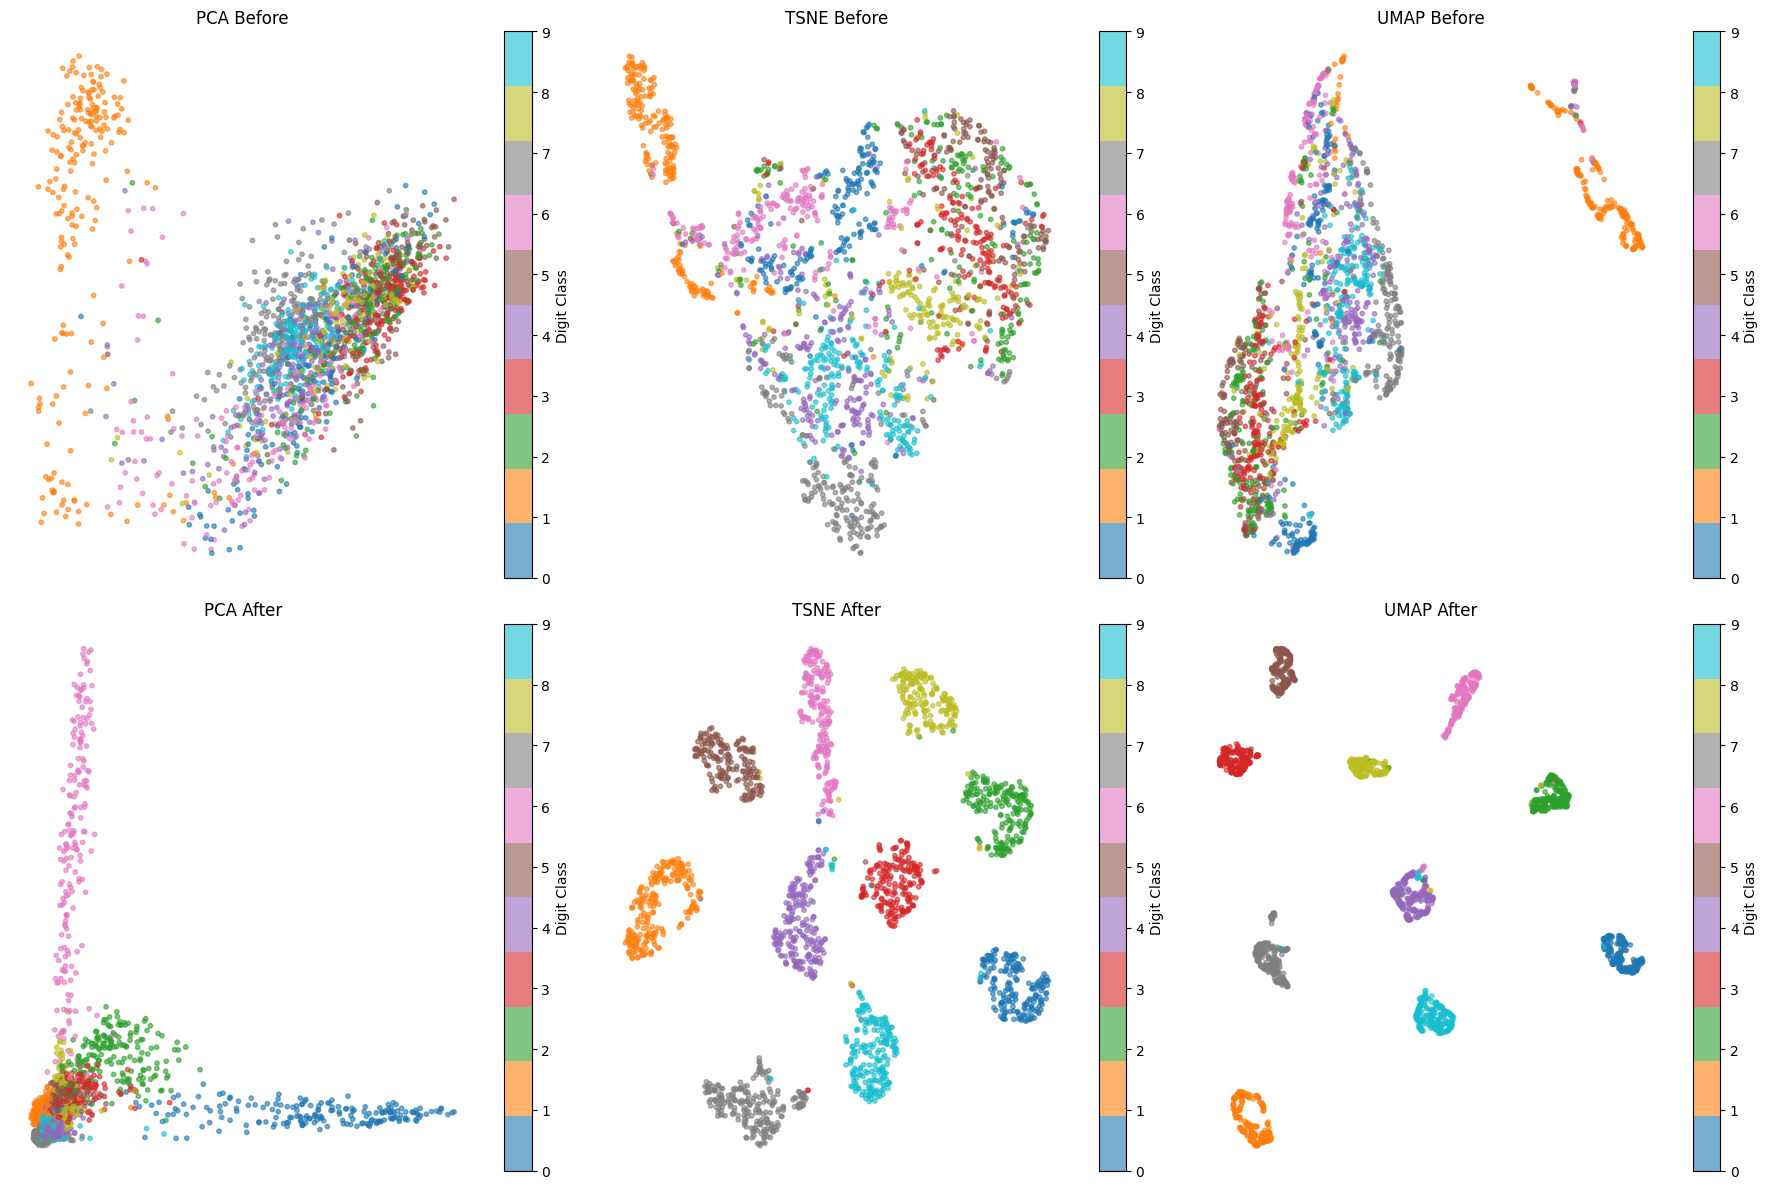

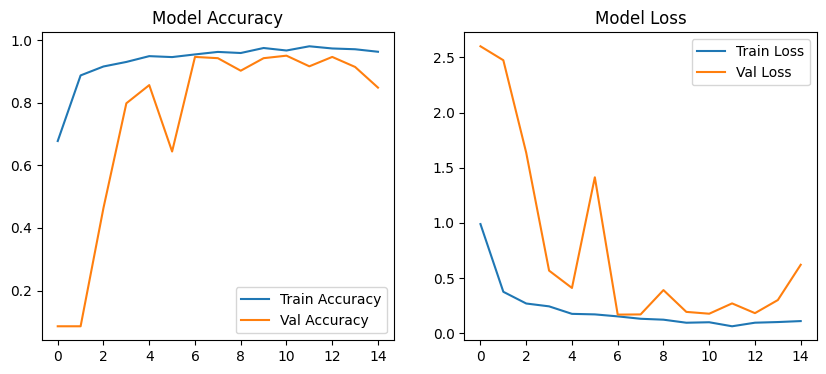

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Convert to 3-channel and resize
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
x_train = tf.image.grayscale_to_rgb(tf.cast(x_train, tf.float32))
x_test = tf.image.grayscale_to_rgb(tf.cast(x_test, tf.float32))
x_train = tf.image.resize(x_train, [64, 64]) / 255.0
x_test = tf.image.resize(x_test, [64, 64]) / 255.0

# Use subset for faster computation
x_train = x_train[:2000]
y_train = y_train[:2000]
x_test = x_test[:500]
y_test = y_test[:500]

# Create base model (ResNet101)
base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(64, 64, 3)
)

# Freeze all layers initially for feature extraction
base_model.trainable = False

# Create feature extractor for BEFORE fine-tuning
feature_extractor_before = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.output
)

# Extract features BEFORE fine-tuning
features_before = feature_extractor_before.predict(x_train, batch_size=32)

# Now prepare for fine-tuning
base_model.trainable = True
# Freeze first 100 layers (adjust as needed)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Build transfer learning model
inputs = tf.keras.Input(shape=(64, 64, 3))
x = base_model(inputs, training=True)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test, y_test)
)

# Create NEW feature extractor for AFTER fine-tuning
feature_extractor_after = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.output
)

# Extract features AFTER fine-tuning
features_after = feature_extractor_after.predict(x_train, batch_size=32)

# Dimensionality reduction and plotting functions
def reduce_dimensions(features, method='pca', pca_components=50):
    """Reduce dimensions using PCA followed by specified method"""
    pca = PCA(n_components=pca_components)
    pca_features = pca.fit_transform(features)

    if method == 'pca':
        return PCA(n_components=2).fit_transform(features)
    elif method == 'tsne':
        return TSNE(n_components=2, perplexity=30, init='pca').fit_transform(pca_features)
    elif method == 'umap':
        return umap.UMAP(n_components=2, n_neighbors=15).fit_transform(pca_features)
    else:
        raise ValueError("Method must be 'pca', 'tsne', or 'umap'")

def plot_embedding(x, y, title, ax=None):
    """Plot 2D embedding with color-coded classes"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, cmap='tab10', s=10, alpha=0.6)
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(scatter, ax=ax, label='Digit Class')

# Create visualizations
methods = ['pca', 'tsne', 'umap']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, method in enumerate(methods):
    # Before fine-tuning
    reduced_before = reduce_dimensions(features_before, method)
    plot_embedding(reduced_before, y_train, f'{method.upper()} Before', axes[0, i])

    # After fine-tuning
    reduced_after = reduce_dimensions(features_after, method)
    plot_embedding(reduced_after, y_train, f'{method.upper()} After', axes[1, i])

plt.tight_layout()
plt.show()

# Optional: Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

1: Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

2: Load and Preprocess MNIST Data

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Convert to 3-channel and resize
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
x_train = tf.image.grayscale_to_rgb(tf.cast(x_train, tf.float32))
x_test = tf.image.grayscale_to_rgb(tf.cast(x_test, tf.float32))
x_train = tf.image.resize(x_train, [64, 64]) / 255.0
x_test = tf.image.resize(x_test, [64, 64]) / 255.0

# Use subset for faster computation
x_train = x_train[:2000]
y_train = y_train[:2000]
x_test = x_test[:500]
y_test = y_test[:500]

3: Initialize Base Model (ResNet101)

In [ ]:
# Create base model (ResNet101)
base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(64, 64, 3)
)

# Freeze all layers initially for feature extraction
base_model.trainable = False

# Create feature extractor for BEFORE fine-tuning
feature_extractor_before = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.output
)

4: Extract Features Before Fine-Tuning

In [ ]:
# Extract features BEFORE fine-tuning
features_before = feature_extractor_before.predict(x_train, batch_size=32)

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step


5: Prepare Model for Fine-Tuning

In [ ]:
# Now prepare for fine-tuning
base_model.trainable = True
# Freeze first 100 layers (adjust as needed)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Build transfer learning model
inputs = tf.keras.Input(shape=(64, 64, 3))
x = base_model(inputs, training=True)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

6: Train the Model

In [ ]:
# Train the model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test, y_test)
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 112s 632ms/step - accuracy: 0.5158 - loss: 1.5398 - val_accuracy: 0.0800 - val_loss: 5.0176
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.8774 - loss: 0.4002 - val_accuracy: 0.1900 - val_loss: 2.1183
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9069 - loss: 0.2761 - val_accuracy: 0.7220 - val_loss: 0.8548
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9205 - loss: 0.2777 - val_accuracy: 0.8340 - val_loss: 0.5120
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9330 - loss: 0.2082 - val_accuracy: 0.7700 - val_loss: 0.8289
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9376 - loss: 0.1919 - val_accuracy: 0.8620 - val_loss: 0.4962
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.9430 - loss: 0.1706 - val_accuracy: 0.7860 - val_loss: 0.9832
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9345 - loss: 0.2100 - val_accuracy: 0.926

7: Extract Features After Fine-Tuning

In [ ]:
# Create NEW feature extractor for AFTER fine-tuning
feature_extractor_after = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.output
)

# Extract features AFTER fine-tuning
features_after = feature_extractor_after.predict(x_train, batch_size=32)

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step


8: Dimensionality Reduction Functions

In [ ]:
def reduce_dimensions(features, method='pca', pca_components=50):
    """Reduce dimensions using PCA followed by specified method"""
    pca = PCA(n_components=pca_components)
    pca_features = pca.fit_transform(features)

    if method == 'pca':
        return PCA(n_components=2).fit_transform(features)
    elif method == 'tsne':
        return TSNE(n_components=2, perplexity=30, init='pca').fit_transform(pca_features)
    elif method == 'umap':
        return umap.UMAP(n_components=2, n_neighbors=15).fit_transform(pca_features)
    else:
        raise ValueError("Method must be 'pca', 'tsne', or 'umap'")

def plot_embedding(x, y, title, ax=None):
    """Plot 2D embedding with color-coded classes"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, cmap='tab10', s=10, alpha=0.6)
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(scatter, ax=ax, label='Digit Class')

9: Visualize Features (Before vs. After Fine-Tuning)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


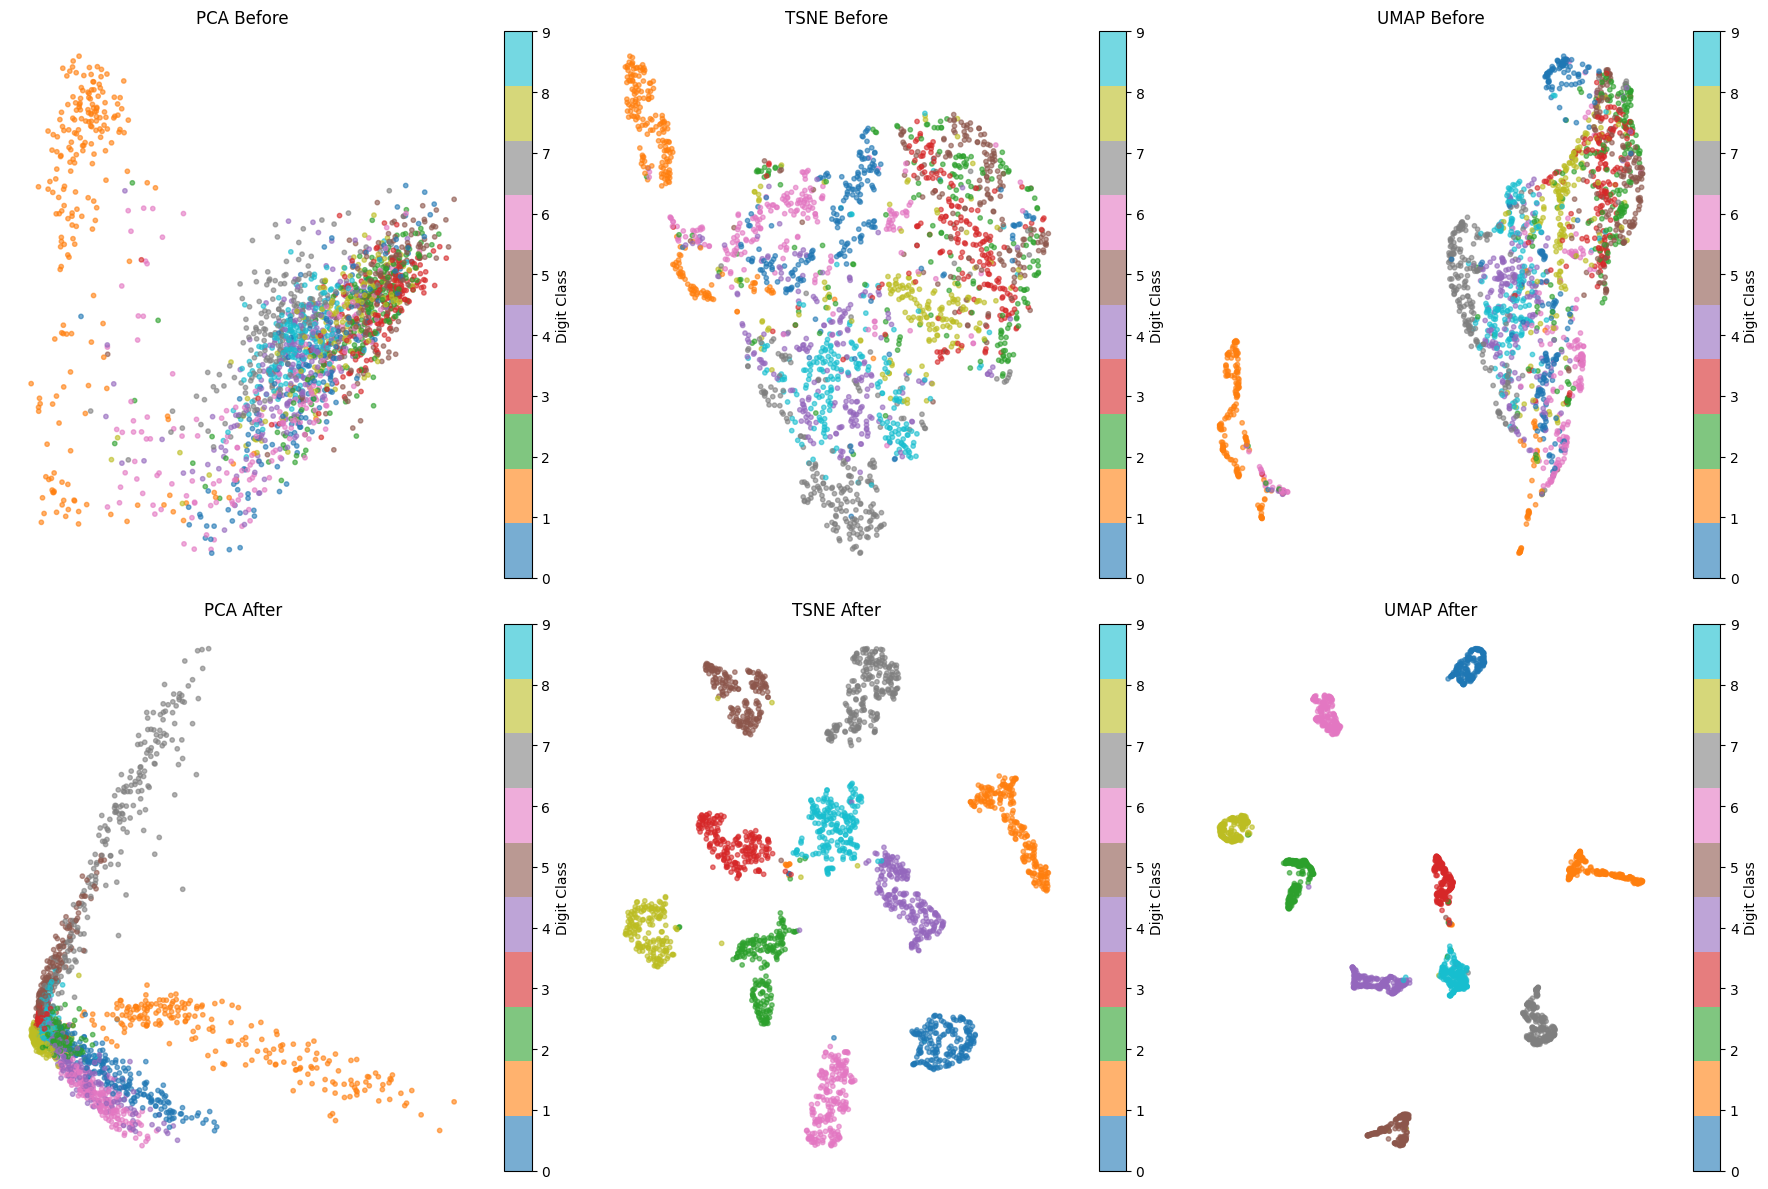

In [ ]:
# Create visualizations
methods = ['pca', 'tsne', 'umap']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, method in enumerate(methods):
    # Before fine-tuning
    reduced_before = reduce_dimensions(features_before, method)
    plot_embedding(reduced_before, y_train, f'{method.upper()} Before', axes[0, i])

    # After fine-tuning
    reduced_after = reduce_dimensions(features_after, method)
    plot_embedding(reduced_after, y_train, f'{method.upper()} After', axes[1, i])

plt.tight_layout()
plt.show()